In [29]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold, StratifiedShuffleSplit, train_test_split, KFold, LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso
from tqdm import tqdm

w

%matplotlib inline

## Задача 1

![img](./9-1.JPG)

## Задача 2

В этой задаче делаю One-hot-encoding для всех категориальных фичей. Валидация LOO. Предсказание на тесте -- усреднее ответов моделей, обученных на трейне

In [603]:
ss = pd.read_csv('./data/9-2-sample.csv', index_col=0)
train = pd.read_csv('./data/9-2-train.csv', index_col=0)

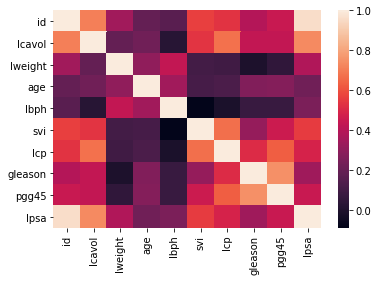

In [604]:
sns.heatmap(df.corr());

In [605]:
train = df[np.logical_not(pd.isna(df['lpsa']))]
test_kaggle = df[pd.isna(df['lpsa'])]
X, y = train.drop('lpsa', axis=1), train['lpsa'].values
X_test_kaggle, y_test_kaggle = test_kaggle.drop('lpsa', axis=1), test_kaggle['lpsa']

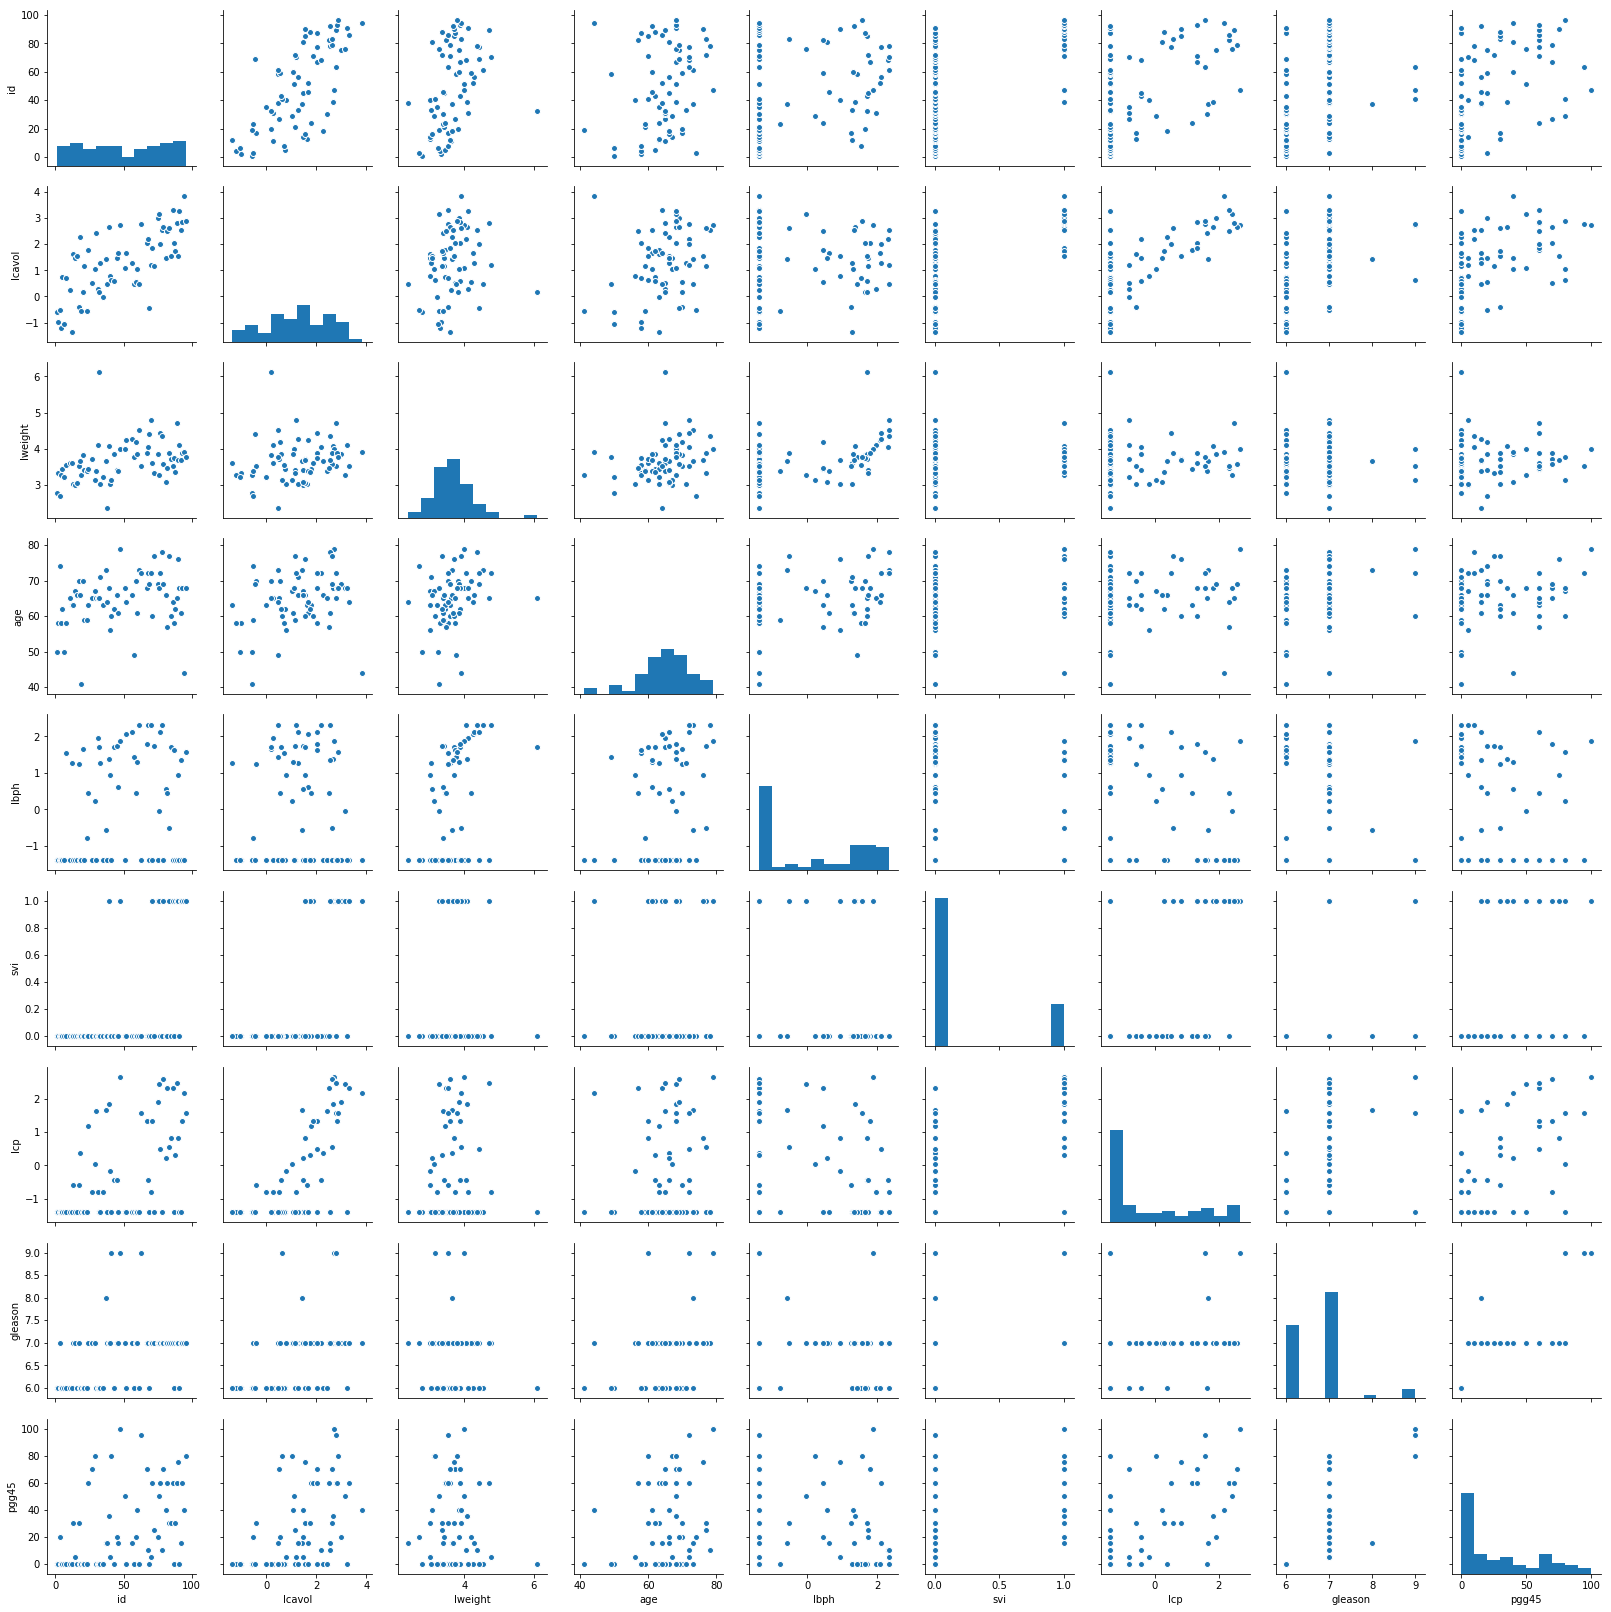

In [606]:
sns.pairplot(X);

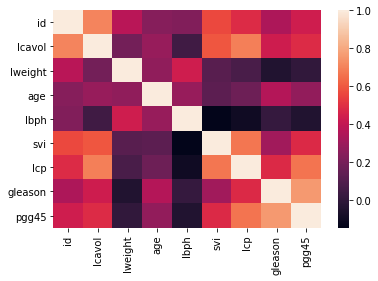

In [607]:
sns.heatmap(X.corr());

In [608]:
for col in X.columns:
    print(col, len(np.unique(X[col])))

id 68
lcavol 65
lweight 67
age 27
lbph 31
svi 2
lcp 25
gleason 4
pgg45 16


сделаем one-hot-кодирование для категориального признака `gleason`

In [609]:
oh_enc = OneHotEncoder(sparse=False)
X_cat_oh = oh_enc.fit_transform(X[['gleason']])
X_not_cat = X.drop(['gleason'], axis=1).values

In [610]:
X = np.hstack((X_cat_oh, X_not_cat))

In [611]:
X.shape

(68, 12)

In [612]:
y_pred = np.zeros_like(y)
estimators = []
for itr, ite in LeaveOneOut(len(y)):
    X_train, y_train, X_test, y_test = X[itr], y[itr], X[ite], y[ite]
    reg = LinearRegression()
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    reg.fit(X_train, y_train)
    y_pred[ite] = reg.predict(X_test)
    estimators.append([scaler, reg])

In [613]:
rmse(y_pred, y)

0.3485038835365015

make submission

In [614]:
X_all, y_all = df.drop('lpsa', axis=1), df['lpsa'].values

In [615]:
X_cat_oh_all = oh_enc.transform(X_all[['gleason']])
X_not_cat_all = X_all.drop(['gleason'], axis=1).values
X_all = np.hstack((X_cat_oh_all, X_not_cat_all))

In [616]:
X_all.shape

(97, 12)

In [617]:
y_pred_kaggle = np.zeros_like(y_all)
for scaler, reg in estimators:
    X_all_scaled = scaler.transform(X_all)
    y_pred_kaggle += reg.predict(X_all_scaled)
y_pred_kaggle = y_pred_kaggle / len(estimators)

In [618]:
ss['lpsa'] = y_pred_kaggle

In [619]:
ss.to_csv('9-2-answ.csv')

#### Второе решение: заметим большую корелляцию между таргетом и id

и восстановим ее:

In [627]:
ss = pd.read_csv('./data/9-2-sample.csv', index_col=0)
train = pd.read_csv('./data/9-2-train.csv')

In [628]:
train = df[np.logical_not(pd.isna(df['lpsa']))]
test_kaggle = df[pd.isna(df['lpsa'])]
X, y = train[['id']], train['lpsa'].values
X_test_kaggle, y_test_kaggle = test_kaggle.drop('lpsa', axis=1), test_kaggle['lpsa']

In [630]:
y_pred = np.zeros_like(y)
estimators = []
for itr, ite in LeaveOneOut(len(y)):
    X_train, y_train, X_test, y_test = X.iloc[itr], y[itr], X.iloc[ite], y[ite]
    reg = LinearRegression()
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    reg.fit(X_train, y_train)
    y_pred[ite] = reg.predict(X_test)
    estimators.append([scaler, reg])

In [631]:
X_all, y_all = df[['id']], df['lpsa'].values

In [632]:
y_pred_kaggle = np.zeros_like(y_all)
for scaler, reg in estimators:
    X_all_scaled = scaler.transform(X_all)
    y_pred_kaggle += reg.predict(X_all_scaled)
y_pred_kaggle = y_pred_kaggle / len(estimators)

In [633]:
ss['lpsa'] = y_pred_kaggle

In [634]:
ss.to_csv('9-2-answ.csv')

## Задача 3

В этой задаче делаю One-hot-encoding для всех категориальных фичей. Валидация LOO. Предсказание на тесте -- усреднее ответов моделей, обученных на трейне

In [238]:
df = pd.read_csv('./data/hw9t3_train.csv', index_col=0)
ss = pd.read_csv('./data/hw9t3_sample.csv', index_col=0)

#### EDA

In [239]:
df.shape

(500, 37)

In [240]:
df[:3]

,Fadeev,Khaldeev,Pepermaldeev,kees,top hat,turtle,gloves,small cart,cardboard,brush,...,elefant,zeta function,Alla Pugachyova,soldering iron,frypan,drums,yellow submarine,sleep,mood,duration
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,0,0,0,1,1,1,1,...,0,1,1,0,0,0,1,3.418333,frivolous,11.851099
1,0,1,1,1,1,1,1,1,0,0,...,0,0,0,1,1,0,1,3.080932,frivolous,NaN
2,0,0,1,1,1,1,1,1,0,1,...,0,0,0,0,0,1,1,3.229007,so-so,3.751619


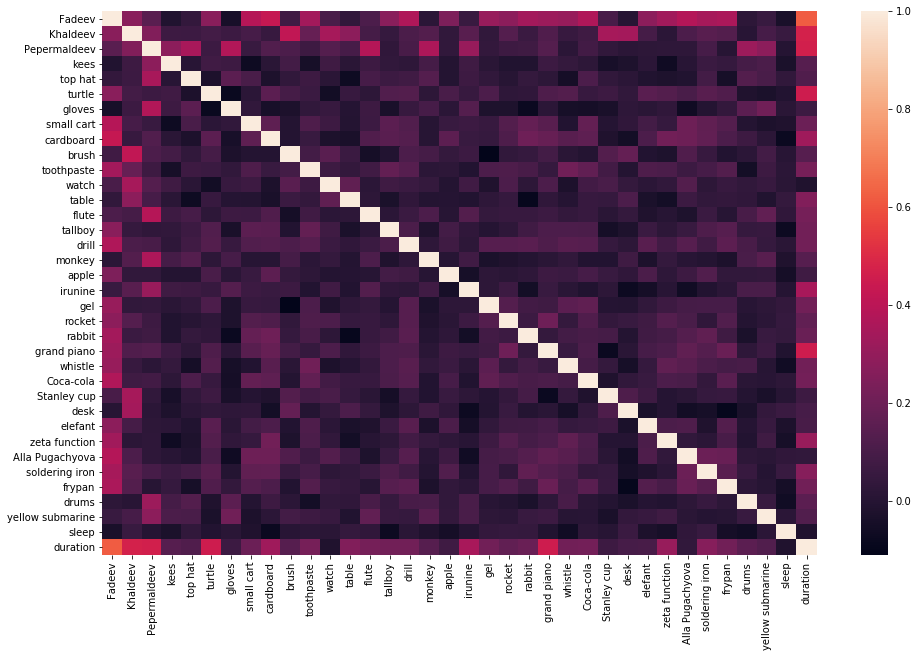

In [241]:
plt.figure(figsize=(16, 10))
sns.heatmap(df.corr())

In [242]:
for col in df.columns:
    print(col, len(np.unique(df[col])))

Fadeev 2
Khaldeev 2
Pepermaldeev 2
kees 2
top hat 2
turtle 2
gloves 2
small cart 2
cardboard 2
brush 2
toothpaste 2
watch 2
table 2
flute 2
tallboy 2
drill 2
monkey 2
apple 2
irunine 2
gel 2
rocket 2
rabbit 2
grand piano 2
whistle 2
Coca-cola 2
Stanley cup 2
desk 2
elefant 2
zeta function 2
Alla Pugachyova 2
soldering iron 2
frypan 2
drums 2
yellow submarine 2
sleep 500
mood 8
duration 500


In [243]:
train = df[np.logical_not(pd.isna(df['duration']))]
test_kaggle = df[pd.isna(df['duration'])]
X, y = train.drop('duration', axis=1), train['duration'].values
X_test_kaggle, y_test_kaggle = test_kaggle.drop('duration', axis=1), test_kaggle['duration']

In [244]:
oh_features = list(set(df.columns) - set(['sleep', 'duration']))

In [245]:
le = LabelEncoder()
X['mood'] = le.fit_transform(X['mood'])

In [246]:
oh_enc = OneHotEncoder(sparse=False)
X_cat_oh = oh_enc.fit_transform(X[oh_features])
X_not_cat = X.drop(oh_features, axis=1).values

In [247]:
X = np.hstack((X_cat_oh, X_not_cat))

In [282]:
y_pred = np.zeros_like(y)
estimators = []
for itr, ite in LeaveOneOut(len(y)):
    X_train, y_train, X_test, y_test = X[itr], y[itr], X[ite], y[ite]
    reg = Ridge(alpha=1)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    reg.fit(X_train, y_train)
    y_pred[ite] = reg.predict(X_test)
    estimators.append([scaler, reg])

In [283]:
rmse(y_pred, y)

1.342028051392952

In [284]:
df.columns

Index(['Fadeev', 'Khaldeev', 'Pepermaldeev', 'kees', 'top hat', 'turtle',
       'gloves', 'small cart', 'cardboard', 'brush', 'toothpaste', 'watch',
       'table', 'flute', 'tallboy', 'drill', 'monkey', 'apple', 'irunine',
       'gel', 'rocket', 'rabbit', 'grand piano', 'whistle', 'Coca-cola',
       'Stanley cup', 'desk', 'elefant', 'zeta function', 'Alla Pugachyova',
       'soldering iron', 'frypan', 'drums', 'yellow submarine', 'sleep',
       'mood', 'duration'],
      dtype='object')

make submission

In [285]:
X_all, y_all = df.drop('duration', axis=1), df['duration'].values
X_all['mood'] = le.transform(X_all['mood'])

In [286]:
X_cat_oh_all = oh_enc.transform(X_all[oh_features])
X_not_cat_all = X_all.drop(oh_features, axis=1).values
X_all = np.hstack((X_cat_oh_all, X_not_cat_all))

In [287]:
y_pred_kaggle = np.zeros_like(y_all)
for scaler, reg in estimators:
    X_all_scaled = scaler.transform(X_all)
#     X_all_scaled = pca.transform(X_all_scaled)
    y_pred_kaggle += reg.predict(X_all_scaled)
y_pred_kaggle = y_pred_kaggle / len(estimators)

In [288]:
y_pred_kaggle[y_pred_kaggle < 0] = 0

In [289]:
np.mean(y_pred_kaggle)

6.186225362965435

In [290]:
rmse(y_pred_kaggle[list(train.index)], y)

1.161980863491907

In [291]:
ss['duration'] = y_pred_kaggle

In [292]:
ss.to_csv('9-3-answ.csv')

## Задача 4

Будем делать LOO не для всего датасета, а для определенного больного. Тем самым обучим несколько моделей для каждого больного поотдельности. На тесте мы уже знаем больного, поэтому для него мы усредняем все ответы моделей, обученных под этого больного

In [95]:
df = pd.read_csv('./data/parkinsons_updrs_train.csv', index_col=-1)
ss = pd.read_csv('./data/parkinsons_updrs_sample.csv', index_col=-1)

In [100]:
for col in df.columns:
    print(col, len(np.unique(df[col])))

subject# 42
age 23
sex 2
test_time 2442
Jitter(%) 1305
Jitter(Abs) 1326
Jitter:RAP 853
Jitter:PPQ5 840
Jitter:DDP 1703
Shimmer 3581
Shimmer(dB) 852
Shimmer:APQ3 2664
Shimmer:APQ5 2850
Shimmer:APQ11 3283
Shimmer:DDA 4223
NHR 5532
HNR 4780
RPDE 5430
DFA 5282
PPE 4777
motor_UPDRS_train 2537
total_UPDRS_train 2581


In [96]:
df[:3]

,subject#,age,sex,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,...,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,motor_UPDRS_train,total_UPDRS_train
id,,,,,,,,,,,,,,,,,,,,,
1,1,72,0,5.6431,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,...,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,28.199,34.398
2,1,72,0,12.6660,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,...,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,NaN,NaN
3,1,72,0,19.6810,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,...,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,28.695,35.389


In [97]:
df.shape

(5875, 22)

In [130]:
target = ['motor_UPDRS_train', 'total_UPDRS_train']
train = df[np.logical_not(pd.isna(df[target[0]]))]
test_kaggle = df[pd.isna(df[target[0]])]
X, y_motor, y_total = train.drop(target, axis=1), train[target[0]], train[target[1]]

обучение моделей

In [131]:
models = {}
y_motor_pred = pd.DataFrame(data=np.zeros_like(y_motor), index=y_motor.index)
y_total_pred = pd.DataFrame(data=np.zeros_like(y_total), index=y_total.index)

for subj in tqdm(np.unique(X['subject#'])):
    if subj not in models:
        models[subj] = []
    
    elems = X['subject#'] == subj
    X_one, y_motor_one, y_total_one = X[elems], y_motor[elems],  y_total[elems]
    estimators = []
    for itr, ite in LeaveOneOut(len(y_motor_one)):
        train_idx, test_idx = list(X_one.iloc[itr].index), list(X_one.iloc[ite].index)
#         print(test_idx)
        X_train, y_motor_train, y_total_train, X_test, y_motor_test, y_total_test = X_one.iloc[itr], y_motor_one.iloc[itr], y_total_one.iloc[itr], X_one.iloc[ite], y_motor_one.iloc[ite], y_motor_one.iloc[ite]
        reg_motor, reg_total = Ridge(alpha=1), Ridge(alpha=1)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        reg_motor.fit(X_train, y_motor_train)
        reg_total.fit(X_train, y_total_train)
        y_motor_pred.loc[test_idx] = reg_motor.predict(X_test)
        y_total_pred.loc[test_idx] = reg_total.predict(X_test)
        estimators.append([scaler, reg_motor, reg_total])
        
    models[subj].append(estimators)

100%|██████████| 42/42 [00:15<00:00,  2.70it/s]


In [123]:
rmse(y_motor_pred, y_motor), rmse(y_total_pred, y_total)

(1.2935027202160896, 1.4274157932664018)

predict

In [124]:
target = ['motor_UPDRS_train', 'total_UPDRS_train']
X, y_motor, y_total = df.drop(target, axis=1), df[target[0]], df[target[1]]

In [125]:
y_motor_pred = np.zeros_like(y_motor)
y_total_pred = np.zeros_like(y_total)

for subj in tqdm(np.unique(X['subject#'])):
    elems = X['subject#'] == subj
    X_one, y_motor_one, y_total_one = X[elems], y_motor[elems],  y_total[elems]
    
    test_idx = list(X_one[elems].index)
    estimators = models[subj][0]
#     print(np.array(estimators).shape)
    for scaler, reg_motor, reg_total in estimators:
        X_one_scaled = scaler.transform(X_one)
        y_motor_pred_one = reg_motor.predict(X_one_scaled)
        y_total_pred_one = reg_total.predict(X_one_scaled)
        y_motor_pred[elems] += y_motor_pred_one
        y_total_pred[elems] += y_total_pred_one
    
    y_motor_pred[elems] = y_motor_pred[elems] / len(estimators) 
    y_total_pred[elems] = y_total_pred[elems] / len(estimators) 

  0%|          | 0/42 [00:00<?, ?it/s]/Users/akupriyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
100%|██████████| 42/42 [00:01<00:00, 33.08it/s]


In [126]:
rmse(y_motor_pred[np.logical_not(pd.isna(y_motor))], y_motor[np.logical_not(pd.isna(y_motor))])

1.1249915878962473

In [127]:
rmse(y_total_pred[np.logical_not(pd.isna(y_total))], y_total[np.logical_not(pd.isna(y_total))])

1.278913799681968

In [118]:
ss['motor_UPDRS'] = y_motor_pred
ss['total_UPDRS'] = y_total_pred

In [119]:
ss.to_csv('9-4.csv')

## Задача 5

В этой задаче последовательно делаю LabelEncoding категориальных фичей ('region', 'school', 'english'), далее One-hot-encoding. Валидация LOO. Предсказание на тесте -- усреднее ответов моделей, обученных на трейне

In [136]:
df = pd.read_csv('./data/hw9t5_train.csv', index_col=0)
ss = pd.read_csv('./data/hw9t5_sample.csv', index_col=0)

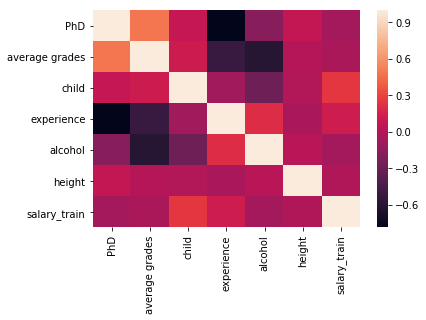

In [137]:
sns.heatmap(df.corr())

### preprocessing

In [138]:
# df.region = df.region.apply(lambda x: x.replace('region', '').strip() if 'region' in x else x)

In [139]:
sex_le = LabelEncoder()
df.sex = sex_le.fit_transform(df.sex)

In [140]:
df.school.loc[pd.isna(df.school)] = 'no_info'

/Users/akupriyanov/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [141]:
df[:8]

,sex,region,school,PhD,average grades,english,child,experience,alcohol,height,salary_train
id,,,,,,,,,,,
0,0,Moscow,other,0,3.50,advanced,1,6,173,173,1152216.0
1,1,Moscow,2,1,4.76,advanced,0,4,87,170,1010287.0
2,1,Krasnodar region,no_info,0,4.22,intermediate,1,6,71,181,1090723.0
3,1,Moscow,other,0,3.34,beginner,1,7,254,169,NaN
4,1,Bashkortostan,no_info,0,4.31,intermediate,0,4,215,189,878325.0
5,1,Moscow region,no_info,0,3.85,intermediate,2,7,113,165,1365288.0
6,1,other,no_info,0,4.43,upper-intermediate,0,7,277,171,1166347.0
7,1,Moscow,1543,0,4.81,upper-intermediate,0,7,177,165,958887.0


In [142]:
for col in df.columns:
    print(col, len(np.unique(df[col])))

sex 2
region 11
school 9
PhD 2
average grades 167
english 5
child 5
experience 8
alcohol 389
height 56
salary_train 999


In [143]:
cat_features = ['sex', 'PhD', 'region', 'child', 'school', 'english', 'experience']

In [144]:
for c_feature in cat_features:
    le = LabelEncoder()
    df[c_feature] = le.fit_transform(df[c_feature])

In [145]:
df[:8]

,sex,region,school,PhD,average grades,english,child,experience,alcohol,height,salary_train
id,,,,,,,,,,,
0,0,4,8,0,3.50,0,1,5,173,173,1152216.0
1,1,4,3,1,4.76,0,0,3,87,170,1010287.0
2,1,3,7,0,4.22,2,1,5,71,181,1090723.0
3,1,4,8,0,3.34,1,1,6,254,169,NaN
4,1,0,7,0,4.31,2,0,3,215,189,878325.0
5,1,5,7,0,3.85,2,2,6,113,165,1365288.0
6,1,10,7,0,4.43,4,0,6,277,171,1166347.0
7,1,4,2,0,4.81,4,0,6,177,165,958887.0


In [146]:
cat_features = ['sex', 'PhD', 'region', 'child', 'school', 'english', 'experience']

In [147]:
target = ['salary_train']
train = df[np.logical_not(pd.isna(df[target])).values]
test_kaggle = df[pd.isna(df[target])]
X, y = train.drop(target, axis=1), train[target].values

In [148]:
oh_enc = OneHotEncoder(sparse=False)
X_cat_oh = oh_enc.fit_transform(X[cat_features])
X_not_cat = X.drop(cat_features, axis=1)
X = np.hstack((X_not_cat, X_cat_oh))

обучение моделей

In [168]:
y_pred = np.zeros_like(y)
estimators = []
for itr, ite in tqdm(LeaveOneOut(len(y))):
    X_train, y_train, X_test, y_test = X[itr], y[itr], X[ite], y[ite]
    reg = Ridge(alpha=5)
#     reg = RandomForestRegressor()
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    reg.fit(X_train, y_train.ravel())
    y_pred[ite] = reg.predict(X_test)
    estimators.append([scaler, reg])

100%|██████████| 764/764 [00:01<00:00, 709.34it/s]


In [169]:
rmse(y_pred, y)

373917.89310780173

make submission

In [170]:
X_all, y_all = df.drop('salary_train', axis=1), df['salary_train'].values

In [171]:
X_cat_oh = oh_enc.transform(X_all[cat_features])
X_not_cat = X_all.drop(cat_features, axis=1)
X_all = np.hstack((X_not_cat, X_cat_oh))

In [172]:
y_pred_kaggle = np.zeros_like(y_all)
for scaler, reg in estimators:
    X_all_scaled = scaler.transform(X_all)
    y_pred_kaggle += reg.predict(X_all_scaled)
y_pred_kaggle = y_pred_kaggle / len(estimators)

In [173]:
rmse(y_pred_kaggle[np.logical_not(pd.isna(df.salary_train))], y_all[np.logical_not(pd.isna(df.salary_train))])

351472.3143608484

In [163]:
ss['salary'] = y_pred_kaggle

In [93]:
ss.to_csv('9-5.csv')